In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def plot_images(X, y, yp, M, N):
    f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N, M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(((X[i*N+j].cpu().numpy().transpose(1, 2, 0)+1)/2*255).astype(np.uint8))
            title = ax[i][j].set_title("P: {}".format(classes[yp[i*N+j].max(dim=0)[1]]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

定义模型结构

In [2]:
# a cifar-10 classifier
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), # 32x32x3 -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1), # 32x32x32 -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2) # 32x32x32 -> 16x16x32
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), # 16x16x32 -> 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1), # 16x16x64 -> 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2) # 16x16x64 -> 8x8x64
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), # 8x8x64 -> 8x8x128
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), # 8x8x128 -> 8x8x128
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2) # 8x8x128 -> 4x4x128
        
        self.output = nn.Sequential(
            nn.Linear(4*4*128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)
        
        x = x.view(-1, 4*4*128)
        x = self.output(x)

        return x

训练函数与测试函数

In [3]:
def train(model, optimizer, trainloader, epoch, device, pretrain=None):
    
    if pretrain is None:
        init_epoch = 0
        loss = nn.CrossEntropyLoss()
        
    else:
        checkpoint = torch.load(pretrain)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        
    for ep in range(init_epoch, epoch):
        
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(trainloader, 0):
            
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            l = loss(outputs, labels)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            running_loss += l.item()
            
        print('epoch: %d, loss: %.4f' % (ep, running_loss / len(trainloader)))
        running_loss = 0.0
                
     
        torch.save({'epoch': ep,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss},
                    'weights.tar')
    
    print('Finish Training')
    
    
def test(model, testloader, device, visible=True):
    
        correct = 0
        total = 0
        
        for images, labels in testloader:
            
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            total += labels.size(0)
            correct += (outputs.max(dim=1)[1] == labels).sum().item()
            
        print('Accuracy of the network on the test images: %.3f %%' % (100.0 * correct / total))

        if visible:
            plot_images(images, labels, outputs, 5, 5)

训练并测试模型

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
        root='data/',
        train=True,
        download=True,
        transform=transform)
testset = torchvision.datasets.CIFAR10(
        root='data/',
        train=False,
        download=True,
        transform=transform)

batch_size = 200
learning_rate = 0.005
epoch = 50

trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0)
testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = CIFAR10Model()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train the model
train(model, optimizer, trainloader, epoch, device)


epoch: 0, loss: 2.0473
epoch: 1, loss: 1.9009
epoch: 2, loss: 1.8230
epoch: 3, loss: 1.7714
epoch: 4, loss: 1.7383
epoch: 5, loss: 1.7153
epoch: 6, loss: 1.6926
epoch: 7, loss: 1.6693
epoch: 8, loss: 1.6543
epoch: 9, loss: 1.6417
epoch: 10, loss: 1.6270
epoch: 11, loss: 1.6157
epoch: 12, loss: 1.6009
epoch: 13, loss: 1.5930
epoch: 14, loss: 1.5845
epoch: 15, loss: 1.5753
epoch: 16, loss: 1.5692
epoch: 17, loss: 1.5597
epoch: 18, loss: 1.5537
epoch: 19, loss: 1.5473
epoch: 20, loss: 1.5407
epoch: 21, loss: 1.5377
epoch: 22, loss: 1.5327
epoch: 23, loss: 1.5302
epoch: 24, loss: 1.5273
epoch: 25, loss: 1.5261
epoch: 26, loss: 1.5237
epoch: 27, loss: 1.5178
epoch: 28, loss: 1.5178
epoch: 29, loss: 1.5148
epoch: 30, loss: 1.5127
epoch: 31, loss: 1.5096
epoch: 32, loss: 1.5096
epoch: 33, loss: 1.5076
epoch: 34, loss: 1.5076
epoch: 35, loss: 1.5070
epoch: 36, loss: 1.5050
epoch: 37, loss: 1.5050
epoch: 38, loss: 1.5049
epoch: 39, loss: 1.5022
epoch: 40, loss: 1.5026
epoch: 41, loss: 1.5009
ep

Accuracy of the network on the test images: 82.040 %


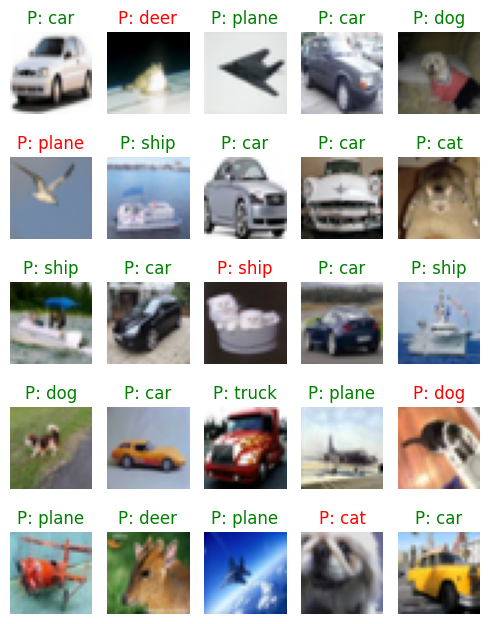

In [6]:
# test the model
model.eval()
test(model, testloader, device)

尝试生成对抗样本并进行可视化

In [7]:
# generate adversarial examples
def fgsm(model, X, y, device, epsilon=0.1):
    
    delta = torch.zeros_like(X, requires_grad=True).to(device)
    loss = nn.CrossEntropyLoss()
    loss_val = loss(model(X + delta), y)
    loss_val.backward()
    
    return epsilon * delta.grad.detach().sign()

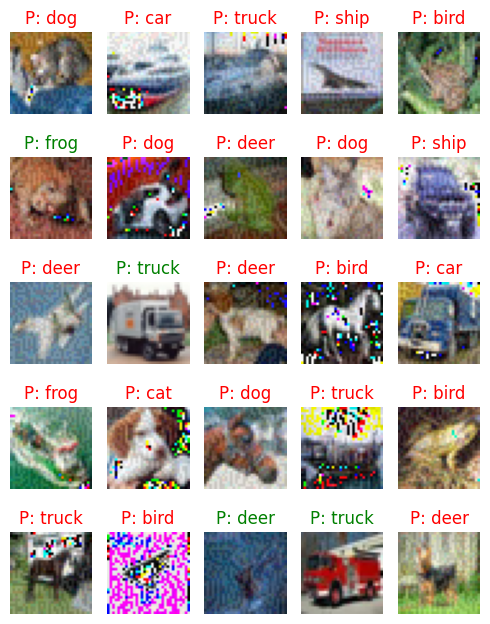

In [8]:
for X, y in testloader:
    X, y = X.to(device), y.to(device)
    break

delta = fgsm(model, X, y, device)
yp = model(X+delta)
plot_images(X+delta, y, yp, 5, 5)

在测试集上测试对抗样本的分类准确率

In [9]:
correct = 0
total = 0

for images, labels in testloader:
    
    images, labels = images.to(device), labels.to(device)
    delta = fgsm(model, images, labels, device)
    outputs = model(images+delta)
    total += labels.size(0)
    correct += (outputs.max(dim=1)[1] == labels).sum().item()
    
print('Accuracy of the network on the test images: %.3f %%' % (100.0 * correct / total))


Accuracy of the network on the test images: 15.520 %


尝试进行对抗训练

In [10]:
# 最后一个参数 ratio 控制对抗样本的比例
def train_adv(model, optimizer, trainloader, epoch, device, pretrain=None, ratio=0.8, epsilon=0.2):
    
    if pretrain is None:
        init_epoch = 0
        loss = nn.CrossEntropyLoss()
        
    else:
        checkpoint = torch.load(pretrain)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        
    for ep in range(init_epoch, epoch):
        
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(trainloader, 0):
            
            images, labels = images.to(device), labels.to(device)
            delta = fgsm(model, images, labels, device, epsilon)
            outputs = model(images+delta if random.random() < ratio else images)
            l = loss(outputs, labels)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            running_loss += l.item()
            
        print('epoch: %d, loss: %.4f' % (ep, running_loss / len(trainloader)))
        running_loss = 0.0
                
     
        torch.save({'epoch': ep,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss},
                    'weights_adv.tar')
    
    print('Finish Training')

In [11]:
model_adv = CIFAR10Model()
model_adv = model_adv.to(device)

optimizer = optim.Adam(model_adv.parameters(), lr=learning_rate)

# train the model
train_adv(model_adv, optimizer, trainloader, 50, device)


epoch: 0, loss: 2.1745
epoch: 1, loss: 2.0205
epoch: 2, loss: 1.9442
epoch: 3, loss: 1.8783
epoch: 4, loss: 1.8166
epoch: 5, loss: 1.7852
epoch: 6, loss: 1.7517
epoch: 7, loss: 1.7275
epoch: 8, loss: 1.7046
epoch: 9, loss: 1.6955
epoch: 10, loss: 1.6765
epoch: 11, loss: 1.6676
epoch: 12, loss: 1.6609
epoch: 13, loss: 1.6520
epoch: 14, loss: 1.6483
epoch: 15, loss: 1.6353
epoch: 16, loss: 1.6274
epoch: 17, loss: 1.6168
epoch: 18, loss: 1.6146
epoch: 19, loss: 1.6101
epoch: 20, loss: 1.5999
epoch: 21, loss: 1.5913
epoch: 22, loss: 1.5859
epoch: 23, loss: 1.5843
epoch: 24, loss: 1.5787
epoch: 25, loss: 1.5755
epoch: 26, loss: 1.5686
epoch: 27, loss: 1.5640
epoch: 28, loss: 1.5608
epoch: 29, loss: 1.5548
epoch: 30, loss: 1.5560
epoch: 31, loss: 1.5536
epoch: 32, loss: 1.5453
epoch: 33, loss: 1.5429
epoch: 34, loss: 1.5417
epoch: 35, loss: 1.5394
epoch: 36, loss: 1.5334
epoch: 37, loss: 1.5344
epoch: 38, loss: 1.5333
epoch: 39, loss: 1.5302
epoch: 40, loss: 1.5247
epoch: 41, loss: 1.5239
ep

Accuracy of the network on the test images: 70.150 %


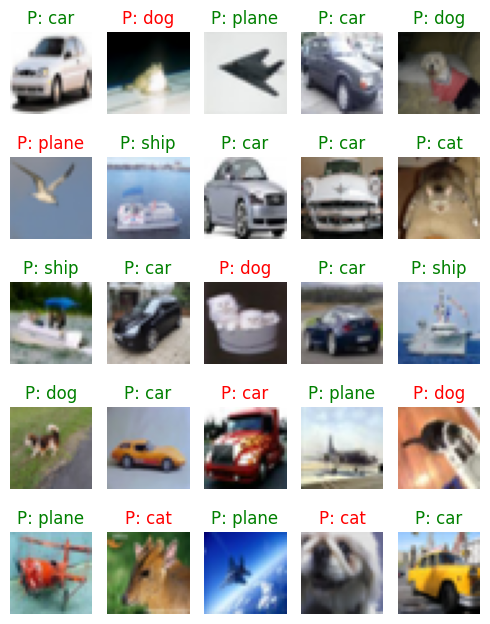

In [12]:
# test the model
model_adv.eval()
test(model_adv, testloader, device)

测试在对抗样本上的分类准确率

In [13]:
correct = 0
total = 0

for images, labels in testloader:
    
    images, labels = images.to(device), labels.to(device)
    delta = fgsm(model_adv, images, labels, device)
    outputs = model_adv(images+delta)
    total += labels.size(0)
    correct += (outputs.max(dim=1)[1] == labels).sum().item()
    
print('Accuracy of the network on the test images: %.3f %%' % (100.0 * correct / total))


Accuracy of the network on the test images: 70.740 %
